In [12]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from __future__ import print_function
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
from scipy.spatial import Delaunay


In [13]:
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''


In [14]:
def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

In [15]:
def compute_SGBM():
    print('loading images...')
    imgL = cv2.imread('im2.png')
    imgR = cv2.imread('im6.png')
    imgLc = cv2.imread('im2.png') # colored image to display
    if imgL is None or imgR is None:
        print('Could not open images')
        return
    print(f"Left image shape: {imgL.shape}, dtype: {imgL.dtype}")
    print(f"Right image shape: {imgR.shape}, dtype: {imgR.dtype}")
    #convertimos a escala de grises
    imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    
    
    window_size = 5
    min_disp = 0 # minimum disparity
    num_disp = 64 - min_disp # number of disparities
    stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
                                    numDisparities = num_disp,
                                    blockSize = 11,
                                    P1 = 8*3*window_size**2,
                                    P2 = 32*3*window_size**2,
                                    disp12MaxDiff = 1,
                                    uniquenessRatio = 10,
                                    speckleWindowSize = 100,
                                    speckleRange = 32
                                    )
    
    print('computing disparity...')
    disparity = stereo.compute(imgL, imgR).astype(np.float32) / 16.0
    colors = cv2.cvtColor(imgLc, cv2.COLOR_BGR2RGB)
    
    print('generating 3D point cloud...')
    h, w = imgL.shape[:2]
    f = 0.8*w # guess for focal length
    Q = np.float32([[1, 0, 0, -0.5*w], 
                 [0, -1, 0, 0.5*h],
                 [0, 0, 0, -f],
                 [0, 0, 1, 0]]) #turn points 180 degrees around x-axis, 
                                #so that y-axis looks up
    points = cv2.reprojectImageTo3D(disparity, Q)
    mask = disparity > disparity.min()
    out_points = points[mask]
    out_colors = colors[mask]
    out_colors = out_colors[~(out_points[:, 2] == -np.inf), :]
    out_points = out_points[~(out_points[:, 2] == -np.inf), :]
    out_fn = 'out.ply'
    write_ply(out_fn, out_points, out_colors)
    print('%s saved' % 'out_ply')
    
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(15, 15))
    ax[0].imshow(imgL, cmap=plt.get_cmap('gray'))
    ax[0].set_title('Left image')
    ax[1].imshow(disparity, cmap=plt.get_cmap('gray'))
    ax[1].set_title('Disparity')
    plt.show()
                                        
    
    
    

Vamos a crear una función para aplicar el filtro Sobel a los puntos de soporte, y así extraer las features $f_n$

Las features $f_n$ son tomadas como una concatenación de derivadas de imagen en un vecindario de $5\times 5$ píxeles alrededor de $(u_n, v_n)$, calculadas con respuestas a un filtro Sobel, dándonos vectores features de dimensión $2\times 5 \times 5 = 50$

Automatically created module for IPython interactive environment
loading images...
Left image shape: (375, 450, 3), dtype: uint8
Right image shape: (375, 450, 3), dtype: uint8
computing disparity...
generating 3D point cloud...
out_ply saved


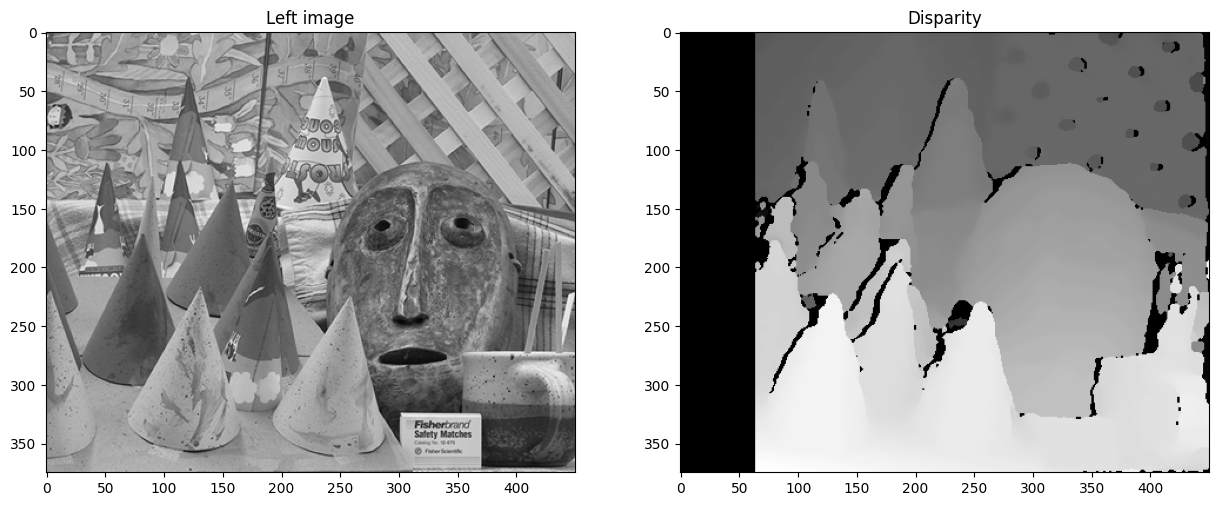

In [16]:
print(__doc__)
compute_SGBM()


Ahora vamos a extrae keypoints en la imagen para mejorar la disparidad, para ello utilizaremos orb, para detectar puntos support

In [17]:
def registerImage_modificada(im1, im2):
    
    #convertimos imágenes a escala de grises
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
    
    #detect ORB features and compute descriptors
    orb =cv2.ORB_create(MAX_FEATURES) #create an ORB object
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None) #detect keypoints and compute descriptors
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
    
    #match features
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = list(matcher.match(descriptors1, descriptors2, None))
    
    
    #sort matches by score
    matches.sort(key=lambda x: x.distance, reverse = False)
    
    #remove not so good matches
    #numGoodMatches = int(len(matches)) #int(len(matches) * GOOD_MATCH_PERCENT)
    #matches = matches[:numGoodMatches]
    #print("Good matches found: {}".format(numGoodMatches))
    
    #ahora imponemos la reestricción epipolar 
    matches_epipolar = []
    for match in matches:
        pt1 = keypoints1[match.queryIdx].pt
        pt2 = keypoints2[match.trainIdx].pt
        if abs(pt1[1] - pt2[1]) < 2:
            matches_epipolar.append(match)
    
    
    #extract location of good matches
    points1 = np.zeros((len(matches_epipolar), 2), dtype=np.float32)
    points2 = np.zeros((len(matches_epipolar), 2), dtype=np.float32)
    
    for i, match in enumerate(matches_epipolar):
        points1[i, :] = keypoints1[match.queryIdx].pt #Se extraen los puntos de la imagen 1
        points2[i, :] = keypoints2[match.trainIdx].pt #Se extraen los puntos de la imagen 2
    
    print(f"Matches antes de la restricción epipolar: {len(matches)}")
    print(f"Matches después de la restricción epipolar: {len(matches_epipolar)}")


    #dibujamos las coincidencias
    img_matches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches_epipolar, None)
    plt.imshow(img_matches)
    plt.axis('off')
    plt.title('Dibujo de puntos soporte')
    plt.show()
    #agregamos puntos en las esquinas
    h, w = im1.shape[:2]
    esquinas = np.array([(0, 0), (w-1, 0), (0, h-1), (w-1, h-1)])
    
    for esquina in esquinas:
        # Buscar el punto más cercano en `points1`
        nearest_idx = np.argmin(np.linalg.norm(points1 - np.array(esquina), axis=1))  
        nearest_d = points1[nearest_idx, 0] - points2[nearest_idx, 0]  # Disparidad del punto más cercano

        # Agregar la esquina con su disparidad interpolada
        points1 = np.vstack([points1, esquina])
        points2 = np.vstack([points2, (esquina[0] - nearest_d, esquina[1])])  # Ajustamos x según la disparidad
    
    print(f"numero total de puntos despues de agregar esquinas: {len(points1)}")
    
    
   

    
    return matches_epipolar, points1, points2
    

In [18]:
def registerImage_modificada2(im1, im2):
    # Convertimos imágenes a escala de grises
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)

    # Detectamos ORB features y computamos descriptores
    orb = cv2.ORB_create(MAX_FEATURES) 
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None) 
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)

    # Hacemos el match de características
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = list(matcher.match(descriptors1, descriptors2, None))

    # Ordenamos los matches por calidad
    matches.sort(key=lambda x: x.distance, reverse=False)

    # Aplicamos la restricción epipolar
    support_points = []
    for match in matches:
        pt1 = keypoints1[match.queryIdx].pt  # (x1, y1) en la imagen izquierda
        pt2 = keypoints2[match.trainIdx].pt  # (x2, y2) en la imagen derecha

        if abs(pt1[1] - pt2[1]) < 2:  # Epipolar constraint
            disparidad = pt1[0] - pt2[0]  # La disparidad es x1 - x2
            support_points.append((int(pt1[0]), int(pt1[1]), disparidad))  # (x, y, d)

    # Agregamos puntos en las esquinas con la disparidad más cercana
    h, w = im1.shape[:2]
    esquinas = [(0, 0), (w-1, 0), (0, h-1), (w-1, h-1)]

    for esquina in esquinas:
        # Encontramos el punto de soporte más cercano
        nearest_d = min(support_points, key=lambda sp: np.linalg.norm(np.array(esquina) - np.array((sp[0], sp[1]))))[2]
        support_points.append((esquina[0], esquina[1], nearest_d))

    support_points = np.array(support_points)  # Convertimos a array de NumPy

    print(f"Total puntos soporte después de agregar esquinas: {len(support_points)}")

    return support_points  # Regresamos un solo conjunto de puntos (x, y, d)


In [19]:
#leer imagen de referencia
refFilename = "im2.png"
imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)

#leer imagen que se quiere registrar
imFilename = "im6.png"
im = cv2.imread(imFilename, cv2.IMREAD_COLOR)

if imReference is None or im is None:
    print("No se pudieron abrir las imágenes")
    exit(0)
    
support_points = registerImage_modificada2(imReference, im)

print(support_points)

Total puntos soporte después de agregar esquinas: 266
[[349.         334.          46.79998779]
 [368.         325.          46.80001831]
 [347.         161.          33.11999512]
 [316.         340.          47.        ]
 [226.         126.          25.92001343]
 [344.         163.          33.1776123 ]
 [353.         336.          47.        ]
 [237.         102.          26.        ]
 [319.         337.          47.        ]
 [218.         135.          25.91999817]
 [219.         136.          26.        ]
 [223.         120.          26.        ]
 [331.         334.          46.79998779]
 [336.         276.          38.88000488]
 [217.         128.          25.91999817]
 [289.         164.          33.11999512]
 [355.         162.          32.83203125]
 [211.         144.          26.        ]
 [230.         126.          26.95680237]
 [336.         278.          39.74398804]
 [226.         136.          26.95680237]
 [226.         137.          26.87387085]
 [358.         334.   

Ya tenemos los puntos soporte, entonces vamos a extraer las features aplicando un filtro sobel

NameError: name 'puntos1' is not defined

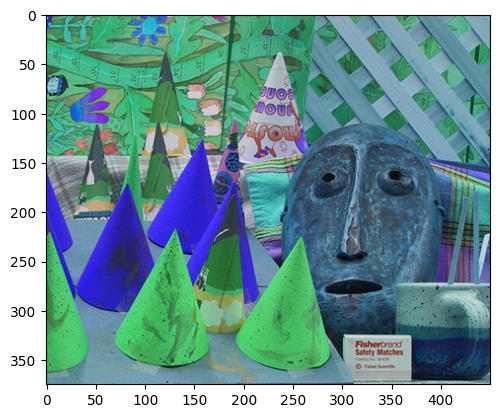

In [20]:
plt.imshow(imReference, cmap='gray')
plt.scatter(puntos1[:, 0], puntos1[:, 1], c='r', s=5, label='Puntos soporte izq')
plt.scatter(puntos2[:, 0], puntos2[:, 1], c='b', s=5, label='Puntos soporte der')
plt.legend()
plt.title("Distribución de puntos soporte")
plt.show()


In [23]:
#aplicamos Delaunay a los puntos soportes de la imagen izquierda
triangulation1 = Delaunay(support_points[:, :2])

#mapa de disparidades esperadas con Delaunay

#print (f"Disparidades: {disparidades}")
print(f"triangulation1.simplices: {triangulation1.simplices}")
print(f"triangulation1.find_simplex(puntos2): {triangulation1.find_simplex(puntos2)}")



triangulation1.simplices: [[263 173 262]
 [193 265 264]
 [ 31  66 263]
 ...
 [160 159 191]
 [ 39 206  18]
 [ 24  39  18]]


NameError: name 'puntos2' is not defined

In [24]:
def disparidades_esperadas4(support_puntos, disparidades, altura, ancho):
    triangulacion = Delaunay(support_puntos)
    disparidades_esperadas = np.zeros((altura, ancho), dtype=np.float32)
    
    for i in range(altura):
        for j in range(ancho):
            simplex = triangulacion.find_simplex((j, i))
            if simplex == -1:
                disparidades_esperadas[i, j] = 0
                continue
            vertices = triangulacion.points[triangulacion.simplices[simplex]]
            u = vertices[:, 0] 
            v = vertices[:, 1]
            d = disparidades[triangulacion.simplices[simplex]]
            
   
            A = np.array([[u[0], v[0], 1],
                          [u[1], v[1], 1], 
                          [u[2], v[2], 1]])
            b = np.array([j, i, 1])
            
            coeficientes = np.linalg.solve(A, b)
            
            
            disparidades_esperadas[i, j] = np.dot(coeficientes, d)
            
    return disparidades_esperadas

In [25]:
disparidades = np.array([p[2] for p in support_points])

In [26]:
def disparidades_esperadas(puntos, disparidades, altura, ancho):
    if len(puntos) < 3:
        return np.zeros((altura, ancho), dtype=np.float32)
    
    # Triangulación de Delaunay
    triangulacion = Delaunay(puntos)
    disparidades_esperadas = np.zeros((altura, ancho), dtype=np.float32)
    
    # Asignar disparidades recorriendo los píxeles
    for y in range(altura):
        for x in range(ancho):
            simplex = triangulacion.find_simplex((x, y))
            if simplex == -1:
                # Si el punto está fuera de los triángulos, asignar 0
                disparidades_esperadas[y, x] = 0
                continue
            
            # Obtener los vértices del triángulo y sus disparidades
            verts = triangulacion.points[triangulacion.simplices[simplex]]
            disp_vals = disparidades[triangulacion.simplices[simplex]]
            
            # Calcular coordenadas baricéntricas
            A = np.vstack((verts.T, np.ones(3)))
            B = np.array([x, y, 1])
            lambdas = np.linalg.solve(A, B)
            
            # Interpolar la disparidad usando las coordenadas baricéntricas
            disparidades_esperadas[y, x] = np.dot(lambdas, disp_vals)
    
    return disparidades_esperadas

In [27]:
prior_map1 = disparidades_esperadas(support_points, disparidades, imReference.shape[0], imReference.shape[1])
plt.imshow(prior_map1, cmap='gray')
print(prior_map1)
print(prior_map1.shape)

ValueError: wrong dimensionality in xi

In [ ]:
def extraccion_features_a_puntos_support(image, support_points):
    #creamos una lista donde irán los feature extraídos
    features = []
    #primero vemos si nuestra imagen ya está en escala de grises
    
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
    #ahora sí aplicamos el filtro sobel sobre x, y
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    
    
    ##BORRAR ESTO IMPRESION DE IMAGEN
    # Magnitud del gradiente (opcional)
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Normalizamos las imágenes para visualización
    sobelx_norm = cv2.normalize(np.abs(sobelx), None, 0, 255, cv2.NORM_MINMAX)
    sobely_norm = cv2.normalize(np.abs(sobely), None, 0, 255, cv2.NORM_MINMAX)
    sobel_mag_norm = cv2.normalize(sobel_magnitude, None, 0, 255, cv2.NORM_MINMAX)

    # Mostramos las imágenes de Sobel
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1), plt.imshow(sobelx_norm, cmap='gray'), plt.title('Sobel X')
    plt.subplot(1, 3, 2), plt.imshow(sobely_norm, cmap='gray'), plt.title('Sobel Y')
    plt.subplot(1, 3, 3), plt.imshow(sobel_mag_norm, cmap='gray'), plt.title('Magnitud del Gradiente')
    plt.show()
    
    #ahora iteramos sobre los puntos soporte
    for punto in support_points:
        x, y = int(punto[0]), int(punto[1]) # convertimos a enteros
        
        #primero extraemos un parche de 5x5 alrededor del punto
        if x >= 2 and y>=2 and x <= image.shape[1] - 3 and y <= image.shape[0] - 3:
            patch_x = sobelx[y-2:y+3, x-2:x+3]
            patch_y = sobely[y-2:y+3, x-2:x+3]
            
            patch_x = patch_x.flatten()
            patch_y = patch_y.flatten()
            
            #y concatenamos 
            vector_feature = np.hstack((patch_x, patch_y))
            features.append(vector_feature)
    
    features = np.array(features)
    print(f"Features extraídos: {features.shape}")
    print(f"Features extraídos: {features}")
    return features
            
            
            

        
    

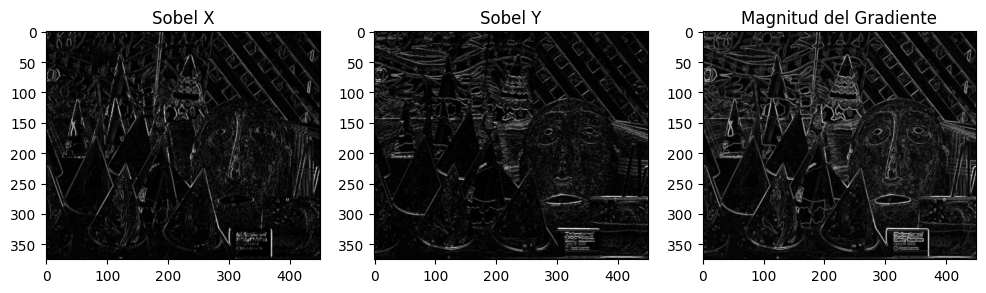

Features extraídos: (262, 50)
Features extraídos: [[   2.  -43.   35. ...  -11.  -10.   19.]
 [  16.    8.  -16. ...   -3.   61.   62.]
 [  44. -145. -186. ...   57.   28.    8.]
 ...
 [  88.  327.  228. ... -114.  -36.   11.]
 [ -39.   12.   32. ...   -1.    2.  -22.]
 [  -2.  -12.   -3. ...  354.  268.  189.]]


In [ ]:
prior_map = extraccion_features_a_puntos_support(imReference, puntos1)

In [ ]:
def funcion_energia2(imgL, imgR, disparidades_esperadas, sigma=3, beta=0.03, gamma=15):
    im1gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    im2gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    altura, ancho = im1gray.shape
    disparity_map = np.zeros((altura, ancho), dtype=np.float32)

    # Aplicamos Sobel a toda la imagen
    sobelxL = cv2.Sobel(im1gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelyL = cv2.Sobel(im1gray, cv2.CV_64F, 0, 1, ksize=3)

    sobelxR = cv2.Sobel(im2gray, cv2.CV_64F, 1, 0, ksize=3)
    sobelyR = cv2.Sobel(im2gray, cv2.CV_64F, 0, 1, ksize=3)
    
    
    for i in range(altura):
        for j in range(ancho):
            mu = disparidades_esperadas[i, j]  # Prior de disparidad obtenido con Delaunay
            rango_disparidad = np.arange(max(0, mu - 3*sigma), min(ancho, mu + 3*sigma + 1))
            print(f"Forma de imgL: {im1gray.shape}")
            print(f"forma de disparidades esperadas: {disparidades_esperadas.shape}")

            mejor_d = 0
            mejor_energia = float('inf')

            for d in rango_disparidad:
                if j - int(d) < 0:
                    continue  # Evita salirse de los límites de la imagen

                # Similitud L1 entre patches de Sobel
                cost = np.abs(sobelxL[i, j] - sobelxR[i, j-int(d)]) + \
                       np.abs(sobelyL[i, j] - sobelyR[i, j-int(d)])

                # Prior basado en la interpolación de Delaunay
                prior = gamma + np.exp(-((d - mu) ** 2) / (2 * sigma ** 2))
                prior = -np.log(prior)

                # Energía total
                energia = beta * cost + prior
                print(f"Energía: {energia}")
                print(f"Mejor energía: {mejor_energia}")


                if energia < mejor_energia:
                    mejor_energia = energia
                    print(f"Nueva mejor energía: {mejor_energia}")
                    mejor_d = d

            disparity_map[i, j] = mejor_d

    return disparity_map


In [ ]:
def funcion_energia(imgL, imgR, disparidades_esperadas, sigma=3, beta=0.03, gamma=15, patch_size=5):
    """
    Calcula un mapa de disparidad minimizando la función de energía E(d) = beta * L1 + prior,
    donde L1 se calcula con un parche Sobel 5x5 (o el patch_size que desees) y
    el prior se basa en - log[ gamma + exp( -((d - mu)^2) / (2*sigma^2) ) ].
    """
    
    # Convertir a gris
    im1gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    im2gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    altura, ancho = im1gray.shape
    print(f"Forma de imgL: {im1gray.shape}")
    print(f"forma de disparidades esperadas: {disparidades_esperadas.shape}")
    
    # Reservar el mapa de disparidades resultante
    disparity_map = np.zeros((altura, ancho), dtype=np.float32)

    # Aplicar Sobel a toda la imagen (x e y)
    sobelxL = cv2.Sobel(im1gray, cv2.CV_64F, 1, 0, ksize=5)
    sobelyL = cv2.Sobel(im1gray, cv2.CV_64F, 0, 1, ksize=5)

    sobelxR = cv2.Sobel(im2gray, cv2.CV_64F, 1, 0, ksize=5)
    sobelyR = cv2.Sobel(im2gray, cv2.CV_64F, 0, 1, ksize=5)
    
    # Para definir el vecindario 5x5:
    mitad = patch_size // 2  # Por ejemplo, patch_size=5 => mitad=2

    for i in range(altura):
        for j in range(ancho):
            
            # "mu" es la disparidad "esperada" en este píxel (Delaunay).
            mu = disparidades_esperadas[i, j]
            
            # Definir el rango de disparidades a explorar:
            d_min = int(max(0, np.floor(mu - 3*sigma)))
            d_max = int(min(ancho-1, np.ceil(mu + 3*sigma)))
            
            mejor_d = 0
            mejor_energia = float('inf')
            
            for d in range(d_min, d_max+1):
                
                # Coordenada en la imagen derecha
                ur = j - d
                
                # Comprobamos que el parche 5x5 (u ±2, v ±2) no se salga de la imagen
                # en la izquierda y la derecha.
                if (ur - mitad < 0 or ur + mitad >= ancho or
                    i - mitad < 0 or i + mitad >= altura or
                    j - mitad < 0 or j + mitad >= ancho):
                    continue
                
                # Extraer parche de Sobel para la izquierda
                patch_left_x = sobelxL[i - mitad : i + mitad + 1,
                                       j - mitad : j + mitad + 1]
                patch_left_y = sobelyL[i - mitad : i + mitad + 1,
                                       j - mitad : j + mitad + 1]
                
                # Extraer parche de Sobel para la derecha (shift en horizontal = d)
                patch_right_x = sobelxR[i - mitad : i + mitad + 1,
                                        ur - mitad : ur + mitad + 1]
                patch_right_y = sobelyR[i - mitad : i + mitad + 1,
                                        ur - mitad : ur + mitad + 1]
                
                # Calcular L1 = suma de |parche_left - parche_right|
                diff_x = np.abs(patch_left_x - patch_right_x)
                diff_y = np.abs(patch_left_y - patch_right_y)
                costo_sobel = np.sum(diff_x) + np.sum(diff_y)
                
                # Prior = - log[ gamma + exp( -((d - mu)^2)/(2*sigma^2) ) ]
                prior = - np.log(gamma + np.exp(-((d - mu)**2) / (2*sigma**2)))
                
                # E(d) = beta * costo_sobel + prior
                energia = beta * costo_sobel + prior
                
                # Minimizamos E(d)
                if energia < mejor_energia:
                    mejor_energia = energia
                    mejor_d = d
            
            # Asignar disparidad final
            disparity_map[i, j] = mejor_d
    
    return disparity_map


In [ ]:
def funcion_energia_nueva(imgL, imgR, disparidades_esperadas, sigma=3, beta=0.03, gamma=15):
    # Convertimos las imágenes a escala de grises si es necesario
    if len(imgL.shape) == 3:
        im1gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    if len(imgR.shape) == 3:
        im2gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    # Convertir a gris
    #im1gray = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    #im2gray = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    
    altura, ancho = im1gray.shape
    print(f"Forma de imgL: {im1gray.shape}")
    print(f"forma de disparidades esperadas: {disparidades_esperadas.shape}")
    
    disparity_map = np.zeros((altura, ancho), dtype=np.float32)
    
    sobelxL = cv2.Sobel(im1gray, cv2.CV_64F, 1, 0, ksize=5)
    sobelyL = cv2.Sobel(im1gray, cv2.CV_64F, 0, 1, ksize=5)

    sobelxR = cv2.Sobel(im2gray, cv2.CV_64F, 1, 0, ksize=5)
    sobelyR = cv2.Sobel(im2gray, cv2.CV_64F, 0, 1, ksize=5)

    # Aplicar un filtro de 5x5 sobre Sobel para suavizar la respuesta
    kernel_size = 5  # Tamaño de la ventana
    sobelxL_f = cv2.boxFilter(sobelxL, -1, (kernel_size, kernel_size))
    sobelyL_f = cv2.boxFilter(sobelyL, -1, (kernel_size, kernel_size))
    sobelxR_f = cv2.boxFilter(sobelxR, -1, (kernel_size, kernel_size))
    sobelyR_f = cv2.boxFilter(sobelyR, -1, (kernel_size, kernel_size))

    for i in range(altura):
        for j in range(ancho):
            mu = disparidades_esperadas[i, j]  
            if np.isnan(mu):
                continue  

            mu = int(round(mu))  
            rango_disparidad = np.arange(max(0, mu - 3*sigma), min(ancho, mu + 3*sigma + 1), dtype=int)

            mejor_d = 0
            mejor_energia = float('inf')

            for d in rango_disparidad:
                if j - d < 0:
                    continue  

                ventana = 5  # Tamaño de la ventana

                # Definir los límites de la vecindad
                y_min = max(0, i - ventana // 2)
                y_max = min(altura, i + ventana // 2 + 1)
                x_min = max(0, j - ventana // 2)
                x_max = min(ancho, j + ventana // 2 + 1)

                # Verificar que x_max - d sigue dentro de la imagen
                if x_min - d < 0 or x_max - d < 0:
                    continue  # Evitar índices fuera de rango

                # Ajustar la ventana izquierda pa   ra que tenga el mismo tamaño que la derecha
                x_max_d = min(x_max - d, ancho)
                x_min_d = max(x_min - d, 0)

                ventana_x_size = x_max_d - x_min_d
                ventana_y_size = y_max - y_min  # La altura siempre es la misma

                # Ajustar la ventana en la imagen izquierda para que coincida con la derecha
                x_max = x_min + ventana_x_size  # Modificar el tamaño de la ventana izquierda

                # Ahora ambas regiones tienen el mismo tamaño
                cost = np.sum(np.abs(sobelxL_f[y_min:y_max, x_min:x_max] - sobelxR_f[y_min:y_max, x_min_d:x_max_d])) + \
                    np.sum(np.abs(sobelyL_f[y_min:y_max, x_min:x_max] - sobelyR_f[y_min:y_max, x_min_d:x_max_d]))



                prior = gamma + np.exp(-((d - mu) ** 2) / (2 * sigma ** 2))
                prior = -np.log(prior)

                energia = beta * cost + prior

                if energia < mejor_energia:
                    mejor_energia = energia
                    mejor_d = d

            disparity_map[i, j] = mejor_d


    return disparity_map


In [ ]:
print(prior_map1)

[[-2.22378654e+01 -2.21080647e+01 -2.19782619e+01 ...  3.57834969e+01
   3.59132996e+01  3.60430984e+01]
 [-2.22344894e+01 -2.24639969e+01 -2.22313671e+01 ...  2.34308496e+04
   2.34834316e+04  6.82676172e+04]
 [-2.22708702e+01 -2.25003796e+01 -2.25815144e+01 ...  2.33602832e+04
   3.71657188e+04  6.80570859e+04]
 ...
 [-3.57321701e+01 -3.59616776e+01  3.62970703e+04 ... -1.23370164e+05
  -1.77721703e+05 -9.84031445e+03]
 [-3.57685509e+01  3.65202500e+04  4.84841445e+04 ... -8.93552891e+04
  -1.23659891e+05 -1.00508477e+04]
 [ 3.67434297e+04  1.37474016e+05  1.36946672e+05 ... -9.77213359e+04
  -9.82486797e+04 -1.77037656e+05]]


In [ ]:
prior_map2 = np.clip(prior_map1, 0, None)

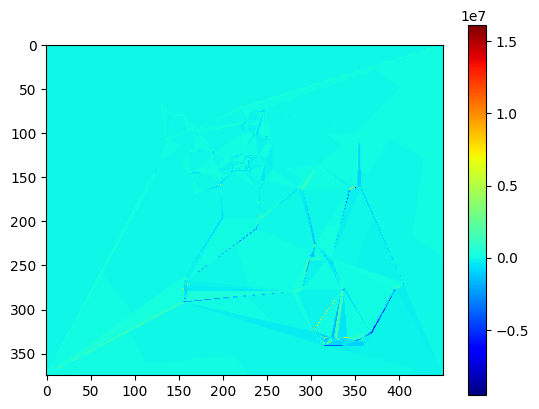

In [ ]:
plt.imshow(prior_map1, cmap='jet')
plt.colorbar()
plt.show()


Forma de imgL: (375, 450)
forma de disparidades esperadas: (375, 450)


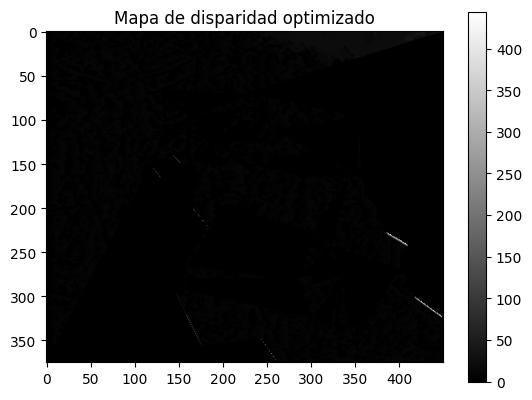

In [ ]:
disparity_map = funcion_energia(imReference, 
                                im, 
                                prior_map2,   # <-- Este sí tiene shape (alto, ancho)
                                sigma=3, 
                                beta=0.03, 
                                gamma=15, 
                                patch_size=3)

plt.imshow(disparity_map, cmap='gray')
plt.title('Mapa de disparidad optimizado')
plt.colorbar()
plt.show()


Forma de imgL: (375, 450)
forma de disparidades esperadas: (375, 450)
[[ 0.  0.  0. ... 39. 40. 41.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]


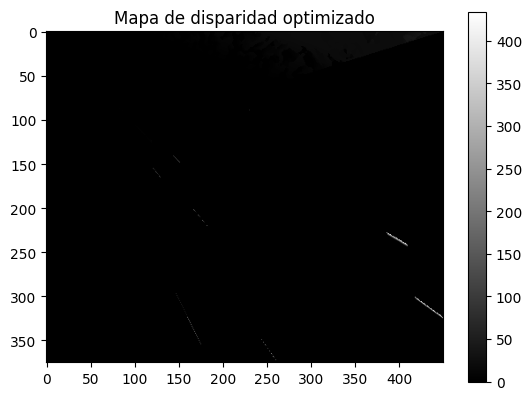

In [ ]:
disparity_map = funcion_energia_nueva(imReference, 
                                im, 
                                prior_map1, # <-- Este sí tiene shape (alto, ancho)
                                sigma=3, 
                                beta=0.03, 
                                gamma=15)
print(disparity_map)
plt.imshow(disparity_map, cmap='gray')
plt.title('Mapa de disparidad optimizado')
plt.colorbar()
plt.show()


In [ ]:
disparity_map = funcion_energia(imReference, im, prior_map)

Forma de imgL: (375, 450)
forma de disparidades esperadas: (262, 50)


IndexError: index 50 is out of bounds for axis 1 with size 50

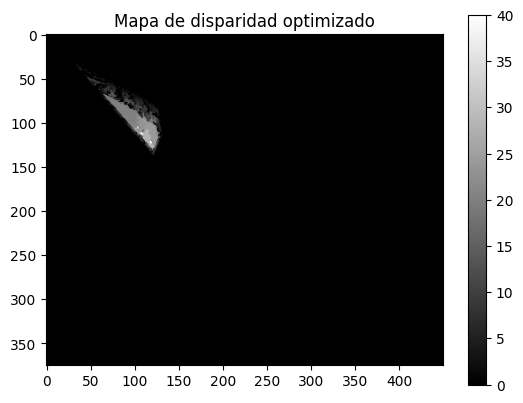

In [ ]:
# Mostrar el resultado
plt.imshow(disparity_map, cmap='gray')
plt.title('Mapa de disparidad optimizado')
plt.colorbar()
plt.show()